In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import time
import behav_annotation
from dlc_utils import *
from behav_annotation import Behav
#from BehavPreprocess import BehavPreprocess
from DimReduction import DimReduction
from Segmentation import Segmentation
from get_results_util import store_results

def fix_layout(width:int=90): 
    from IPython.core.display import display, HTML 
    display(HTML("<style>.container { width:" + str(width) + "% !important; }</style>")) 

fix_layout()
start_time = time.time()

In [2]:
from BehavPreprocess import BehavPreprocess

# Reading Data & Preprocessing

In [3]:
data_root_dir = behav_annotation.dlc_live
train_dataset = BehavPreprocess(data_root_dir, ti=None, tf=None, samp_rate=30, min_frequency=1, max_frequency=15, 
                                num_channels=20, bound_len=50, smooth=True, mean_center=True, normalize=True, 
                                no_bounds=True, dump_rest=False, cut_data=True)
train_data = train_dataset.train_data #preprocess_data
experiment = {'Preprocess':train_dataset.preprocess_dict}

Number of experiments: 2
Experiments shape: (10, 88325)
Training directories: ['C:\\Users\\olimp\\Documents\\ki_paper\\data\\375529_7\\blackfly_375529_2021-07-25_7_DLC.hdf5', 'C:\\Users\\olimp\\Documents\\ki_paper\\data\\375530_7\\blackfly_375530_2021-07-25_7_DLC.hdf5']
Total of 0 nan or inf
Smoothing postural time-series with a low pass filter
Performing time-frequency analysis
Wavelet center frequencies: [15.         13.00743664 11.27956053  9.78121126  8.48189905  7.3551843
  6.37813958  5.5308831   4.7961741   4.15906205  3.6065824   3.12749281
  2.7120443   2.35178296  2.03937786  1.76847188  1.5335524   1.32983904
  1.15318647  1.        ]
Normalizing expression matrix columns
Data concat shape (200, 179154)
Loaded 179154 frames from 2 folders 
Data preprocessing completed. Time elapsed: 121.47496128082275 seconds
Preprocessed masked data shape: (200, 179154)


# Dimensionality Reduction

In [ ]:
# Techniques: kernel_PCA=0, t_SNE=1, tsne=2, Par_tsne=3, Par_tsne2=4, Isomap=5, Umap=6, Par_Umap=7, PCA=8 || 2,3,5&6 FIXME.
low_dim = DimReduction(train_data.copy(), None, technique=2, tsne_perplexity=30, n_iter=2000, 
                       learning_rate=500.0, method='exact', metric='kld', verbose=1)
data_embed = low_dim.data_embed
experiment['Embedding'] = low_dim.embedding_dict

Performing tsne with parameters: {'train': {'no_dims': 2, 'initial_dims': 100, 'perplexity': 30, 'max_iter': 2000, 'initial_momentum': 0.5, 'final_momentum': 0.8, 'eta': 500, 'min_gain': 0.01, 'early_exaggeration': 12.0, 'stop_lying_iter': 100}, 'val': {}}
Creating a 9100x9100 pairwise distance matrix with KL divergence


# Segmentation of low dimensional space

In [10]:
# Techniques: Watershed=0, GMM=1, HDBSCAN=2, HAC=3, random=4
clustering = Segmentation(data_embed, technique=1, xmax=1200, ymax=1200, mesh_mag=2)
clust_labels = clustering.clust_labels
experiment['Clustering'] = clustering.clustering_dict

Performing GMM clustering with parameters: {'n_components': 125, 'covariance_type': 'full'}
Number of clusters: 125
Clustering completed. Time elapsed: 4.216824531555176 seconds


# Store results 

In [11]:
save_path = store_results(experiment,"C:\\Users\\jhflc\\OneDrive\\Documentos\\Projects\\KI_article\\results",
                          start_time)

# Plot some results (testing)

In [12]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import skeleton

def plot_pose(poits2d, save_path, samp_rt, file_names, plot_x=True,
              experiment=0, file_name='plot', fig_sz=(18,4)):
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=fig_sz)
    landmarks = skeleton.point_names
    colors = pl.cm.viridis(np.linspace(0,1,len(landmarks)))
    if plot_x:
        for i in range(len(landmarks)):
            ax.plot(poits2d[experiment][i*2,:], alpha=1,
                    color=colors[i], label=landmarks[i]) #points2d order is x,y,x,y,...
        ax.set_ylabel('X')
    else:
        for i in range(len(landmarks)):
            ax.plot(poits2d[experiment][i*2+1,:], alpha=1,
                    color=colors[i], label=landmarks[i])
        ax.set_ylabel('Y')
    ax.set_xlabel(f'Time instances (fs={samp_rt}Hz)')
    ax.set_title(f'Pose plot: {behav_annotation.train_names[experiment]}')
    ax.legend()
#     ax.grid()
    plt.savefig(save_path+'/'+file_name+'.png')    
#     plt.show()

def plot_wavelets(wav_exp_list, points2d, file_names, landmarks, n_chan, samp_rt, save_path,
                  experiment=0, fig_sz=(12,12), file_name='wavelets_plot', show_rest=False, rest_mask=None, alpha=.5):
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=fig_sz)
    d = points2d[experiment].copy()
    n_series = len(landmarks)*2 #x and y 
    alphas = np.ones_like(wav_exp_list[experiment]) 
    if show_rest:    
        mask = rest_mask * np.shape(alphas)[0]
        alphas[mask] = alpha
    ax.imshow(wav_exp_list[experiment], alpha=alphas, aspect='auto')
    for i in range(n_series):
        d[i,:] = ((-d[i,:] + np.mean(d[i,:]))*(n_chan/2)/(max(d[i,:])-min(d[i,:]))) + ((n_series-i)-1/2)*n_chan
    ax.plot(np.transpose(d), alpha=0.8, c='white')
    ax.set(title=f'Wavelet transform: {file_names[experiment]}',
            xlabel=f'Time instances (fs={samp_rt}Hz)', ylabel='Wavelet frequency weights (background) & pose values (white)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_yticklabels([])  
    for i in range(n_series):
        tags = [[name+'_x', name+'_y'] for name in landmarks]
        tags = [item for sublist in tags for item in sublist]
        ax.annotate(tags[n_series-i-1], 
                    xy=(0, n_chan*(i-1/2)+n_chan),  xycoords='data',
            rotation=90, size=12, va='center', horizontalalignment='right', verticalalignment='top')
    ax.tick_params(axis='both', which='both', length=0) 
    plt.savefig(save_path+'/'+file_name+'.png')
    
def plot_embedding2D(data_embed, frame_amps, save_path, file_names, embed_algs, technique,
                     file_name='embed_plot', size=None, fig_sz=(12,12), a=0.7):
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=fig_sz)
    emb = ax.scatter(data_embed[:,0], data_embed[:,1], s=size, c=frame_amps, marker=None, cmap='viridis',
                     alpha=a)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Embedded Data with '+embed_algs[technique])
    cbar = fig.colorbar(emb)
    cbar.set_label('Frame amplitudes')
#     ax.grid()
    plt.savefig(save_path+'/'+file_name+'.png')    
#     plt.show()

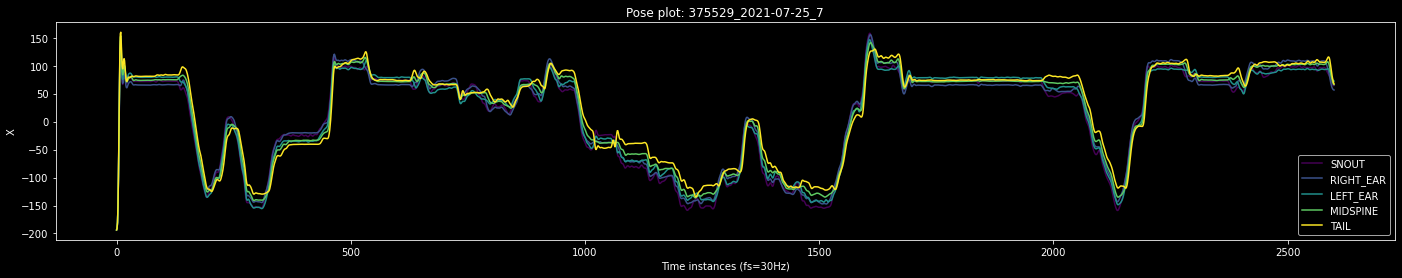

In [13]:
plot_pose(train_dataset.pts2d_exp_list, save_path, train_dataset.samp_rate, behav_annotation.train_dir, 
          experiment=0, file_name='2dpose_plot', fig_sz=(24,4))

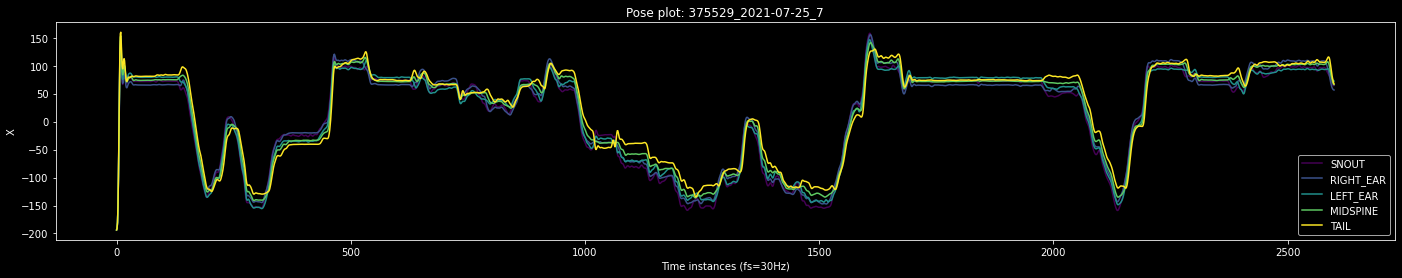

In [14]:
plot_pose(train_dataset.f_pts2d_exp_list, save_path, train_dataset.samp_rate, behav_annotation.train_dir, 
          experiment=0, file_name='2d_pose_smooth', fig_sz=(24,4))

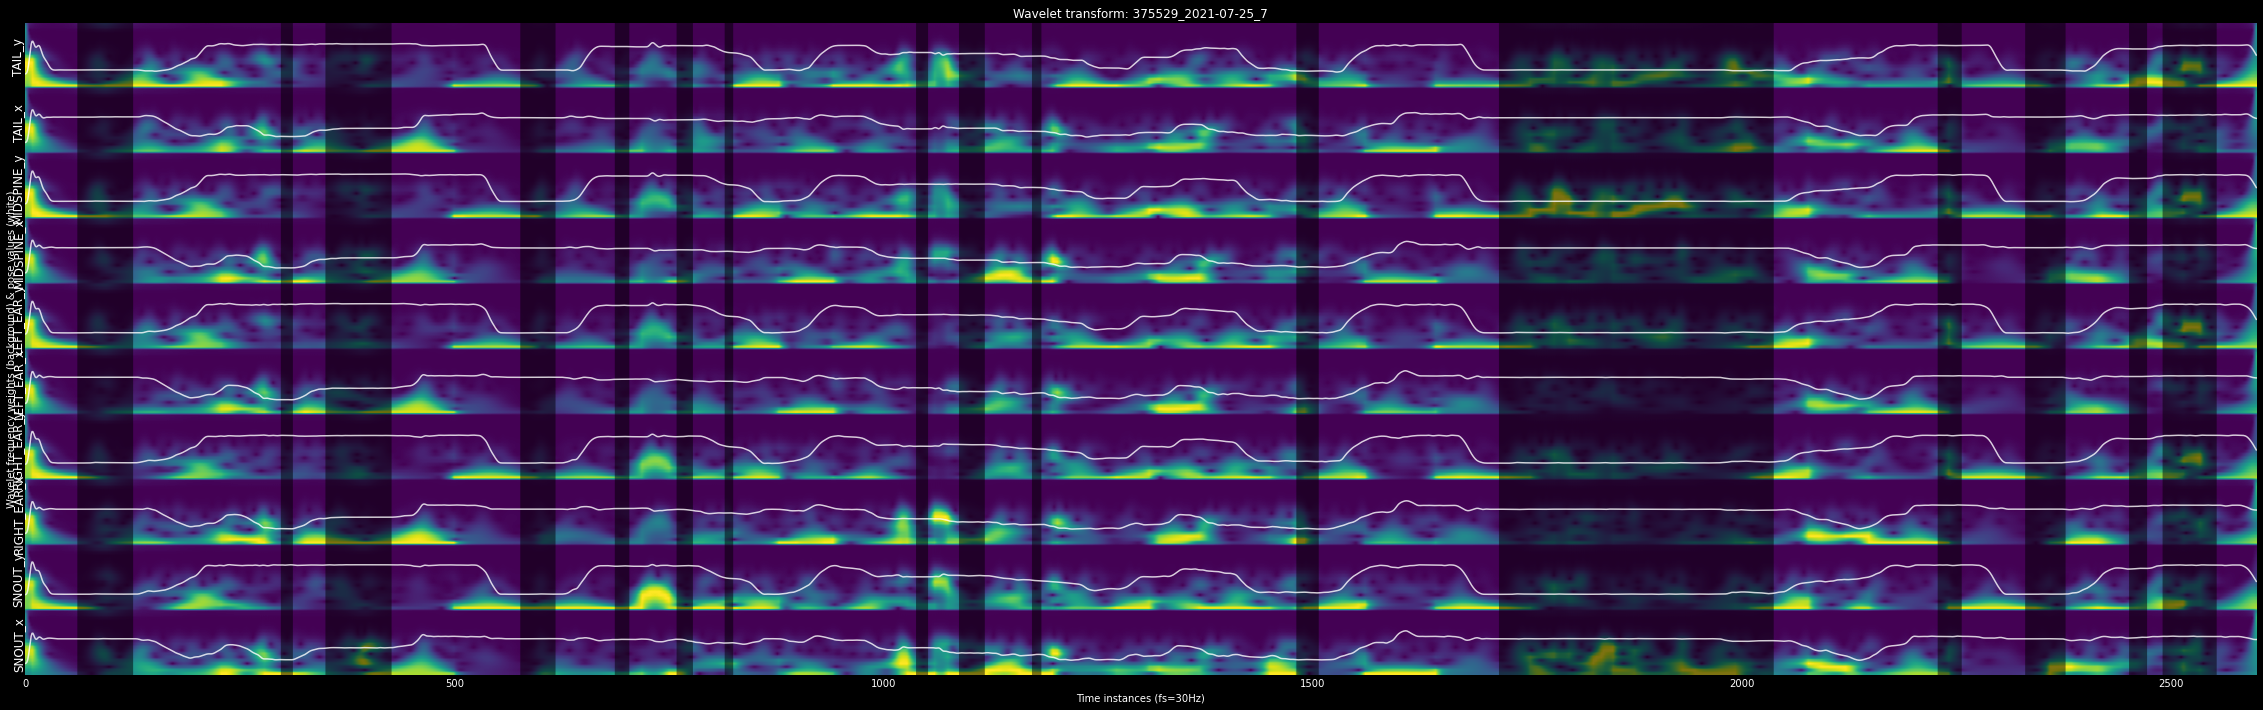

In [15]:
plot_wavelets(train_dataset.wav_exp_list, train_dataset.f_pts2d_exp_list, behav_annotation.train_names,
              train_dataset.mouse_points, train_dataset.num_channels, train_dataset.samp_rate, save_path, 
              experiment=0, fig_sz=(40,12), show_rest=True, rest_mask=train_dataset.preprocess_dict['Data']['Rest_mask'])

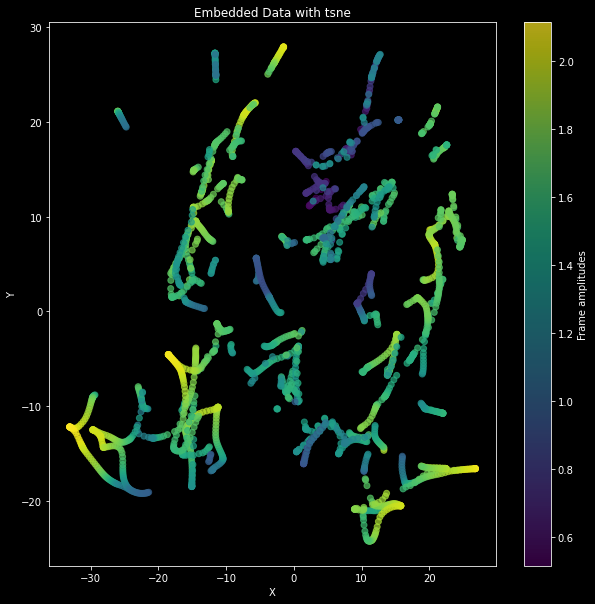

In [20]:
plot_embedding2D(data_embed, train_dataset.frame_amplitudes, save_path, behav_annotation.train_names, low_dim.embed_algs, 
                 low_dim.technique, file_name='embed_plot', size=None, fig_sz=(10,10))